# Campo diario de evapotranspiración de referencia

Ejemplo para calcular la evapotranspiración de referencia (ET0). <br />
*Example to calculate the reference evapotranspiration(ET0).*

In [8]:
# Importamos las librerías necesarias  (en caso de ser necesario, instalar utilizando el comando pip install)
# We import the necessary libraries    (if needed, install by using the command pip install)
import xarray as xr
import h5netcdf
import datetime
import numpy as np
import metpy.calc as mpcalc
import metpy.constants as constants
import matplotlib.pyplot as plt

Definimos la fecha y hora de inicialización del pronóstico: <br />
*We define the forecast initialization date:* 

In [2]:
init_year = 2022
init_month = 12
init_day = 19
init_hour = 0
INIT_DATE = datetime.datetime(init_year, init_month, init_day, init_hour)

Leemos los archivos para todos los plazos de pronóstico: <br />
*We read the files for all forecast lead times:*

In [ ]:
start_lead_time = 0
end_lead_time = 72

files = ['WRFDETAR_01H_{:%Y%m%d_%H}_{:03d}.nc'.format(INIT_DATE, lead_time) for lead_time in range(start_lead_time, end_lead_time + 1)]
print(files)
ds_list = []
for filename in files:
    print(filename)
    ds_tmp = xr.open_dataset(filename, decode_coords = 'all', engine = 'h5netcdf')
    ds_list.append(ds_tmp)

# Combinamos los archivos en un unico dataset
# We combine all the files in one dataset
ds = xr.combine_by_coords(ds_list, combine_attrs = 'drop_conflicts')

Definimos una función para calcular la evapotranspiracion de referencia diaria usando la [ecuación FAO Penman-Monteith](https://www.fao.org/3/x0490e/x0490e06.htm#equation
): <br />
*We define a function to calculate the daily reference evapotranspiration using the [FAO Penman-Monteith equation](https://www.fao.org/3/x0490e/x0490e06.htm#equation
):*





In [28]:
def calc_ET0(ds):

    ds = ds.metpy.quantify()

    days = np.unique(ds['time'].astype('datetime64[D]'))

    if ds['time'][0].dt.hour != 0:
        days = days[1:]

    ET0_list = []
    for n, day in enumerate(days[:-1]):

        #Calculamos valores medios diarios de las variables meteorologicas
        #We calculate the daily mean meteorological variables
        ds_mean = ds[['magViento10', 'PSFC', 'T2', 'HR2']].sel(time = slice(days[n], days[n+1])).mean(dim = 'time')

        #Radiacion acumulada durante el dia
        #Accumulated radiation during the day
        lwd_day = (ds['ACLWDNB'].sel(time = days[n + 1]) - ds['ACLWDNB'].sel(time = days[n])) # Onda larga entrante / Longwave downward
        lwu_day = (ds['ACLWUPB'].sel(time = days[n + 1]) - ds['ACLWUPB'].sel(time = days[n])) # Onda larga saliente / Longwave upward
        swd_day = (ds['ACSWDNB'].sel(time = days[n + 1]) - ds['ACSWDNB'].sel(time = days[n])) # Onda corta entrante / Shortwave downward
        swu_day = 0.23*swd_day # Onda corta saliente / Shortwave upward

        #Radiacion neta [MJ/m**2]
        #Net radiation [MJ/m**2]
        rn_day = ((swd_day - swu_day) + (lwd_day - lwu_day)).metpy.convert_units('MJ/m**2').metpy.dequantify()

        #Calculamos la velocidad del viento a 2m [m/s]
        #We calculate 2m wind speed [m/s]
        wind2m_day = (0.745 * ds_mean['magViento10']).metpy.dequantify()

        #Calculamos la constante psicrometrica [kPa/°C]
        #We calculate the psychrometric constant [kPa/°C]
        gamma = ((constants.dry_air_spec_heat_press * ds_mean['PSFC'])/(constants.molecular_weight_ratio * constants.water_heat_vaporization)).metpy.convert_units('kPa/degC').metpy.dequantify()

        #Calculamos la presion parcial de vapor de saturación [kPa]
        #We calculate the vapour pressure of the air at saturation [kPa]
        es2m_day = (mpcalc.saturation_vapor_pressure(ds_mean['T2'])).metpy.convert_units('kPa').metpy.dequantify()

        ds_mean = ds_mean.metpy.dequantify()

        #Calculamos la pendiente de la curva de presión de vapor:
        #We calculate the slope of the vapour pressure curve
        delta_num = 4098*0.6108*np.exp(17.27*ds_mean['T2']/(ds_mean['T2'] + 237.3))
        delta_den = (ds_mean['T2'] + 237.3)**2
        delta = delta_num/delta_den

        #Calculamos la ET0 [mm/dia]
        #We calculate de ET0 [mm/day]
        ET0_num1 = 0.408*delta*(rn_day)
        ET0_num2 = gamma * (900/(ds_mean['T2'] + 273))*wind2m_day*es2m_day*(1 - ds_mean['HR2']/100)
        ET0_den = delta + gamma*(1 + 0.34*wind2m_day)

        ET0_day = (ET0_num1 + ET0_num2)/ET0_den

        #Donde ET0 resulta negativa, reemplazamos por cero
        #Where ET0 is negative, we change it by zero
        ET0_day = ET0_day.where(ET0_day >= 0, 0)

        ET0_day.name = 'ET0'
        ET0_day = ET0_day.expand_dims({'time':[day]})

        ET0_list.append(ET0_day)

    ET0_total = xr.concat(ET0_list, dim = 'time')

    return ET0_total


Calculamos la ET0 diaria y graficamos el campo del primer dia: <br />
*We calculate the daily ET0 and plot the first day field:*


<xarray.DataArray 'ET0' (time: 3, y: 1249, x: 999)>
array([[[1.8377368 , 1.8380306 , 1.757885  , ..., 1.2131037 ,
         1.2759935 , 1.2636969 ],
        [2.4010937 , 2.2634723 , 2.2361212 , ..., 2.1309147 ,
         2.1691701 , 1.2843804 ],
        [2.4013255 , 2.269537  , 2.2549813 , ..., 2.4349709 ,
         2.4369216 , 2.0401027 ],
        ...,
        [4.5761905 , 4.530478  , 4.469456  , ..., 2.153481  ,
         2.1805608 , 0.8865798 ],
        [4.5864882 , 4.5539856 , 4.531487  , ..., 2.4519515 ,
         2.5991702 , 1.1183857 ],
        [4.5969915 , 4.5943255 , 4.58986   , ..., 3.9974713 ,
         4.0706496 , 3.9879375 ]],

       [[0.74822795, 0.72444373, 0.61294144, ..., 2.727043  ,
         2.6539927 , 2.5749247 ],
        [1.0734799 , 1.719262  , 1.5893562 , ..., 2.5021706 ,
         2.5193615 , 1.9277971 ],
        [1.0110108 , 1.6393281 , 1.4942633 , ..., 2.3523874 ,
         2.4097998 , 1.7624133 ],
...
        [4.465109  , 4.441847  , 4.3565636 , ..., 4.2922564 ,
   

<ipython-input-37-3b377cddb4be>:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ET0['lon'], ET0['lat'], ET0.isel(time = 0))


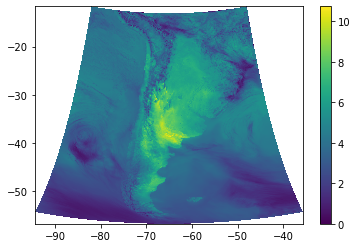

In [37]:
ET0 = calc_ET0(ds)
print(ET0)

plt.pcolormesh(ET0['lon'], ET0['lat'], ET0.isel(time = 0))
plt.colorbar()